<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/hackathon_bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackaton Bank Binary Imbalanced Classification

In [1]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/bank.csv'
url_full = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/bank_full.csv'

bank = pd.read_csv(url_train, sep= ';')
bank_full = pd.read_csv(url_full, sep = ';')

bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [3]:
bank_full.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [4]:
bank_full.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
soma = 0
for column in bank_full.columns:
  if bank_full[column].dtype == 'object':
    n = bank_full.loc[bank_full[column].isnull() == True].count()    
    print(bank_full[column].value_counts(), '\n')    
    soma +=0
print('Sum of null values across the dataframe = {}'.format(soma))

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

no     44396
yes      815
Name: default, dtype: int64 

yes    25130
no     20081
Name: housing, dtype: int64 

no     37967
yes     7244
Name: loan, dtype: int64 

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64 

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64 

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome

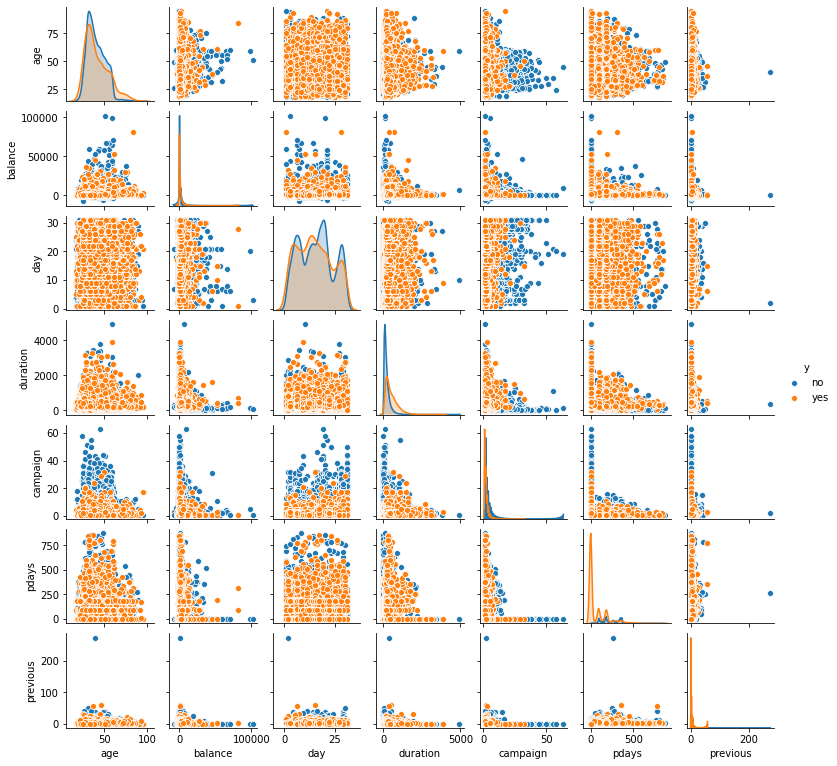

In [6]:
sns.pairplot(bank_full, hue= 'y', height= 1.5)

In [0]:
# data preprocessing 
# considering there is no null value across the dataframe

from sklearn.preprocessing import LabelEncoder, StandardScaler

ss = StandardScaler()
le = LabelEncoder()

for column in bank_full.columns:
  if bank_full[column].dtype == 'object':
    bank_full[column] = le.fit_transform(bank_full[column])



In [0]:
from sklearn.model_selection import train_test_split


x = bank_full.copy().drop(['y'], axis= 1)
y = bank_full.copy()['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state= 42, stratify= y)

In [9]:
y_test.value_counts()

0    11977
1     1587
Name: y, dtype: int64

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix


class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]

xgb_class = XGBClassifier()
xgb_class = XGBClassifier(scale_pos_weight= class_weight, seed= 42)
xgb_class.fit(x_train, y_train)

y_real = y_test
y_pred = xgb_class.predict(x_test)

f1_score = f1_score(y_pred, y_real)
confusion_matrix = confusion_matrix(y_pred, y_real)

print(' F1 score = {:.3f} \n'.format(f1_score), '\n',
      'Confusion matrix \n',
      confusion_matrix)

 F1 score = 0.546 
 
 Confusion matrix 
 [[9876  203]
 [2101 1384]]


In [26]:
bank_full.columns
bank_full_novo = pd.DataFrame(columns= bank_full.columns)

bank_full_novo

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
